In [2]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.io import loadmat
import numpy.lib.stride_tricks

uploaded = files.upload() #Upload the file

filename = next(iter(uploaded)) # Load the data
data = loadmat(filename)

cube = data['indian_pines']

print(f"Image data loaded into variable 'cube' with shape: {cube.shape}")

Saving Indian_pines.mat to Indian_pines.mat
Image data loaded into variable 'cube' with shape: (145, 145, 220)


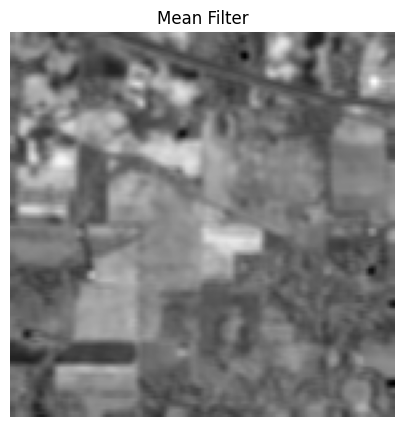

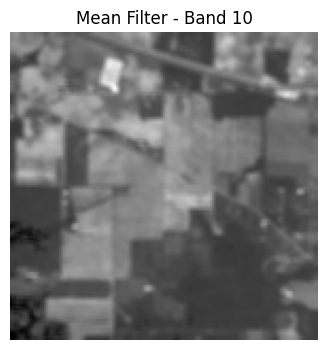

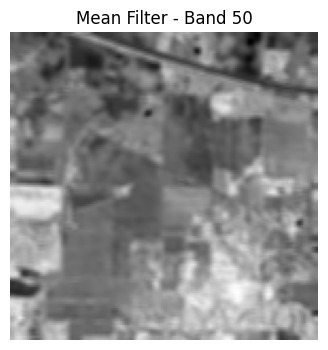

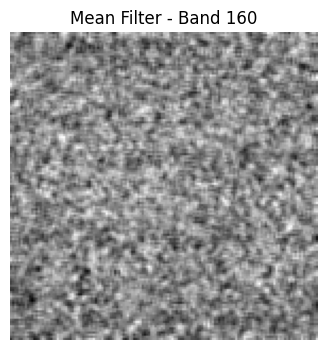

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def mean_filter(cube, kernel_size=3):
    H, W, B = cube.shape
    pad = kernel_size // 2
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    filtered_cube = np.zeros_like(cube, dtype=np.float32)

    for b in range(B):
        band = cube[:, :, b]
        padded = np.pad(band, pad, mode='reflect')
        out = np.zeros((H, W), dtype=np.float32)

        for i in range(H):
            for j in range(W):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                out[i, j] = np.sum(region * kernel)

        filtered_cube[:, :, b] = out

    return filtered_cube

mean_cube = mean_filter(cube, kernel_size=3)

avg_mean = np.mean(mean_cube, axis=2)

plt.figure(figsize=(5,5))
plt.imshow(avg_mean, cmap='gray')
plt.title("Mean Filter")
plt.axis('off')

extra_bands = [10, 50, 160]

for b in extra_bands:
    plt.figure(figsize=(4,4))
    plt.imshow(mean_cube[:, :, b], cmap='gray')
    plt.title(f"Mean Filter - Band {b}")
    plt.axis('off')

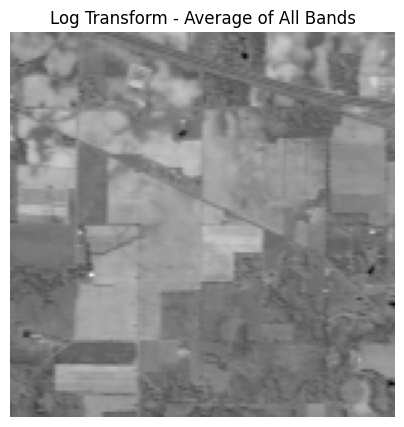

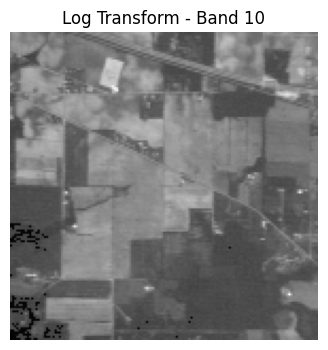

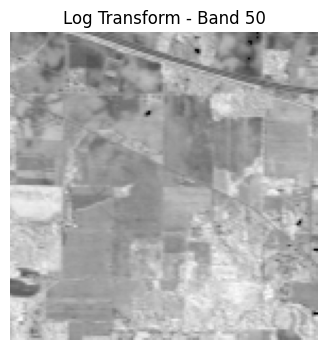

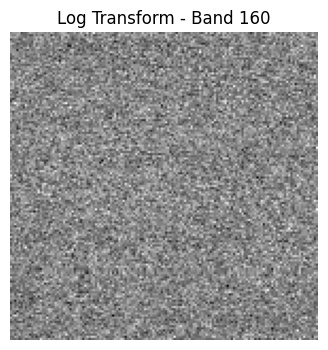

In [6]:
def log_transform(cube, constant=1):
    cube = cube.astype(np.float32)
    # Log transform
    log_cube = constant * np.log1p(cube)
    log_cube = log_cube / np.max(log_cube)
    return log_cube

log_result = log_transform(cube, constant=1)
avg_band = np.mean(log_result, axis=2)

# Plotting results
plt.figure(figsize=(5,5))
plt.imshow(avg_band, cmap='gray')
plt.title("Log Transform - Average of All Bands")
plt.axis('off')

extra_bands = [10, 50, 160]
for b in extra_bands:
    plt.figure(figsize=(4,4))
    plt.imshow(log_result[:, :, b], cmap='gray')
    plt.title(f"Log Transform - Band {b}")
    plt.axis('off')
plt.show()

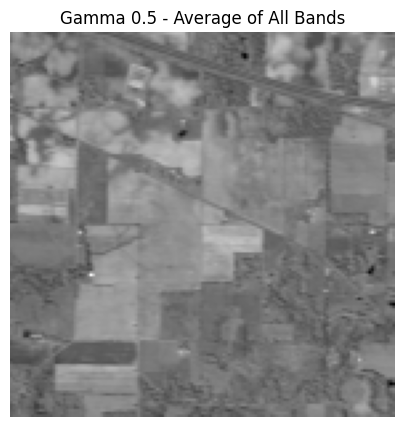

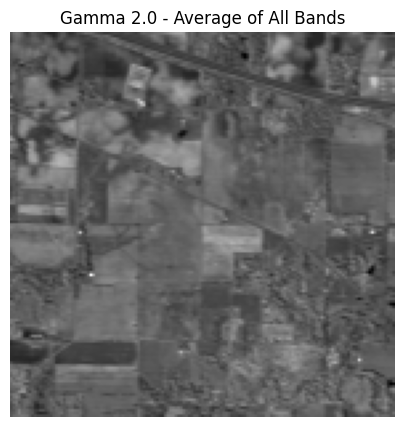

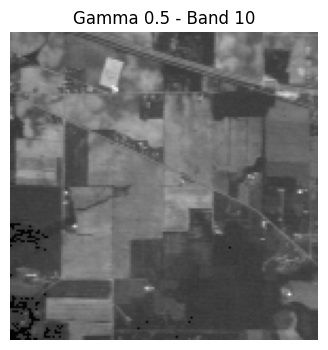

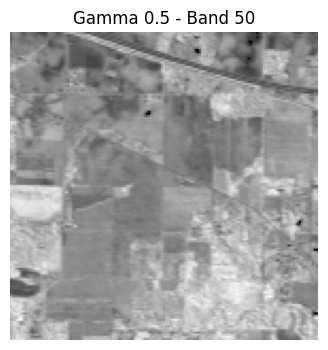

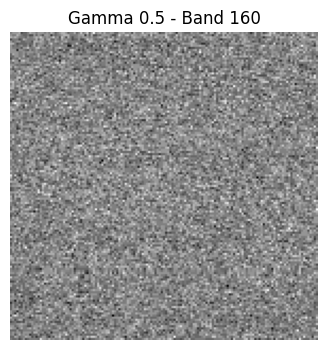

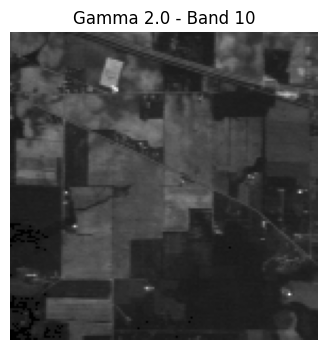

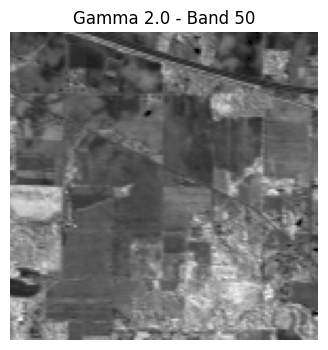

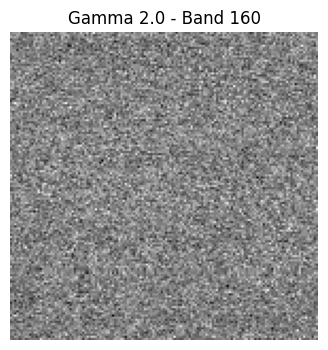

In [7]:
def gamma_correction(cube, gamma=1.0, constant=1.0):
    cube = cube.astype(np.float32)
    norm_cube = cube / np.max(cube)

    gamma_cube = constant * (norm_cube ** gamma)  # applying gamma correction
    gamma_cube = np.clip(gamma_cube, 0, 1)
    return gamma_cube

gamma_bright = gamma_correction(cube, gamma=0.5)
gamma_dark = gamma_correction(cube, gamma=2.0)
avg_bright = np.mean(gamma_bright, axis=2)
avg_dark = np.mean(gamma_dark, axis=2)

# Plotting Average Bands
plt.figure(figsize=(5,5))
plt.imshow(avg_bright, cmap='gray')
plt.title("Gamma 0.5 - Average of All Bands")
plt.axis('off')

plt.figure(figsize=(5,5))
plt.imshow(avg_dark, cmap='gray')
plt.title("Gamma 2.0 - Average of All Bands")
plt.axis('off')

# Plotting Specific Bands
bands_to_show = [10, 50, 160]

for i in bands_to_show:
    plt.figure(figsize=(4,4))
    plt.imshow(gamma_bright[:, :, i], cmap='gray')
    plt.title(f"Gamma 0.5 - Band {i}")
    plt.axis('off')

for i in bands_to_show:
    plt.figure(figsize=(4,4))
    plt.imshow(gamma_dark[:, :, i], cmap='gray')
    plt.title(f"Gamma 2.0 - Band {i}")
    plt.axis('off')
plt.show()

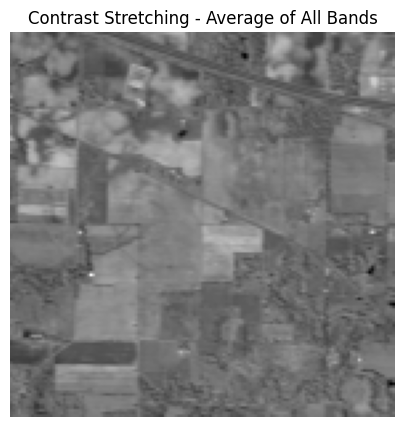

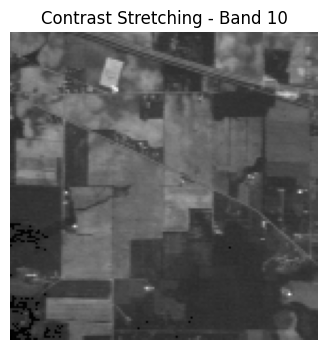

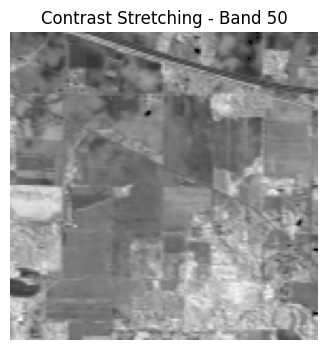

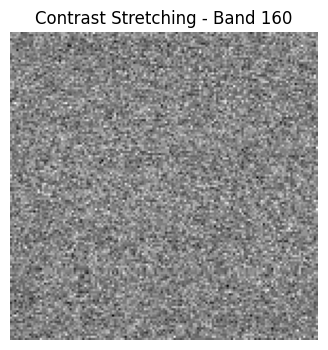

In [8]:
def contrast_stretch(cube):
    c = cube.astype(np.float32)

    # Calculate min/max across the entire cube
    r_min = np.min(c)
    r_max = np.max(c)

    stretched = (c - r_min) / (r_max - r_min) # contrast stretching formula

    stretched = np.clip(stretched, 0, 1)
    return stretched

stretched_cube = contrast_stretch(cube)
avg_stretch = np.mean(stretched_cube, axis=2)

# Plotting Average Band
plt.figure(figsize=(5,5))
plt.imshow(avg_stretch, cmap='gray')
plt.title("Contrast Stretching - Average of All Bands")
plt.axis('off')

# Plotting Specific Bands
extra_bands = [10, 50, 160]
for b in extra_bands:
    plt.figure(figsize=(4,4))
    plt.imshow(stretched_cube[:, :, b], cmap='gray')
    plt.title(f"Contrast Stretching - Band {b}")
    plt.axis('off')
plt.show()

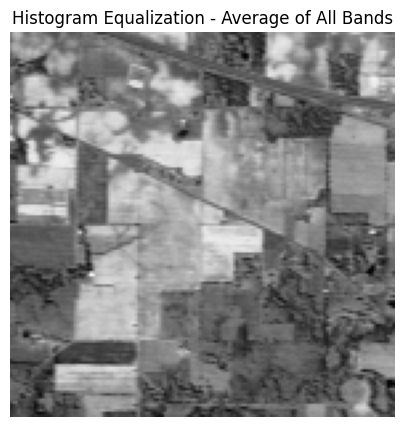

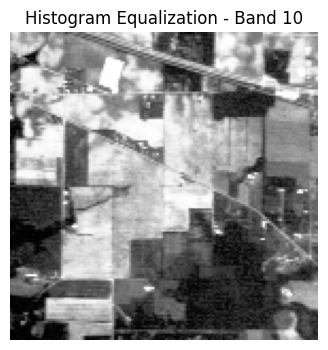

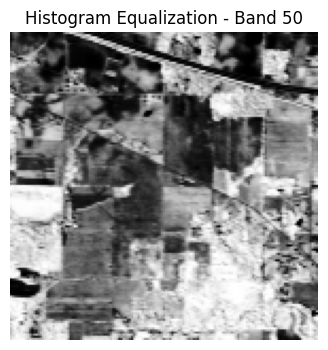

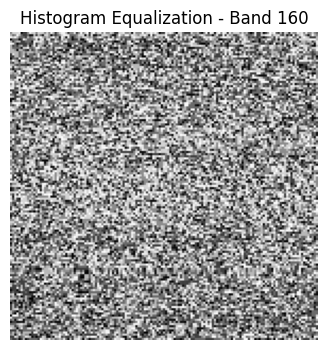

In [9]:
def hist_equalization(cube):
    c = cube.astype(np.float32)
    J, K, L = c.shape  # J=Rows, K=Cols, L=Bands
    equalized_c = np.zeros_like(c)

    for i in range(L):
        band = c[:, :, i]
        band_min = band.min()
        band_max = band.max()
        band_norm = (band - band_min) / (band_max - band_min)

        flat = band_norm.flatten()

        hist, bins = np.histogram(flat, bins=256, range=[0, 1]) #Calculate Histogram and CDF
        cdf = hist.cumsum()

        cdf_normalized = cdf / cdf[-1]
        mapping = np.interp(band_norm.flatten(), bins[:-1], cdf_normalized)

        equalized_band = mapping.reshape(J, K)

        equalized_c[:, :, i] = equalized_band

    return equalized_c

eq_c = hist_equalization(cube)
avg_eq = np.mean(eq_c, axis=2)

# Plotting Average Band
plt.figure(figsize=(5,5))
plt.imshow(avg_eq, cmap='gray')
plt.title("Histogram Equalization - Average of All Bands")
plt.axis('off')

# Plotting Specific Bands
extra_bands = [10, 50, 160]
for i in extra_bands:
    plt.figure(figsize=(4,4))
    plt.imshow(eq_c[:, :, i], cmap='gray')
    plt.title(f"Histogram Equalization - Band {i}")
    plt.axis('off')
plt.show()

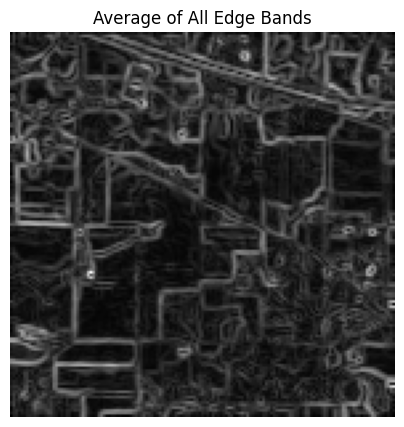

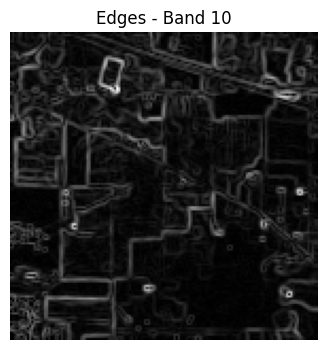

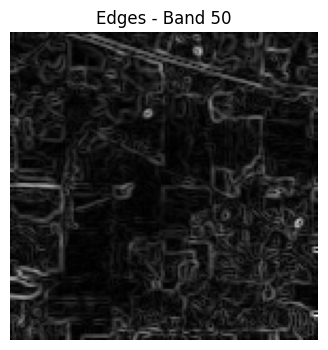

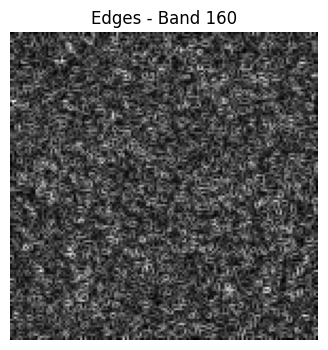

In [10]:

def np_pad(array, pad_width, mode='constant', **kwargs):
    return np.pad(array, pad_width, mode=mode, **kwargs)

def gradient_filter(cube):
    c = cube.astype(np.float32)
    J, K, L = c.shape
    p = 1 # Padding size

    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    grad_c = np.zeros_like(c, dtype=np.float32)

    for i in range(L):
        band = c[:, :, i]

        padded = np_pad(band, p, mode='reflect')
        out = np.zeros((J, K), dtype=np.float32)

        # Convolution
        for m in range(J):
            for j in range(K):
                region = padded[m:m+3, j:j+3]

                gx = np.sum(region * Gx) # apply convolution for Gx and Gy
                gy = np.sum(region * Gy)

                out[m, j] = np.sqrt(gx**2 + gy**2)

        grad_c[:, :, i] = out

    return grad_c

edges_c = gradient_filter(cube)
avg_edges = np.mean(edges_c, axis=2)

# Plotting Average Band
plt.figure(figsize=(5,5))
plt.imshow(avg_edges, cmap='gray')
plt.title("Average of All Edge Bands")
plt.axis('off')

# Plotting Specific Bands
for i in [10, 50, 160]:
    plt.figure(figsize=(4,4))
    plt.imshow(edges_c[:, :, i], cmap='gray')
    plt.title(f"Edges - Band {i}")
    plt.axis('off')
plt.show()